In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [7]:
plt.rcParams["figure.figsize"] = (12, 6)

In [9]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [10]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
dt = datetime.now()
end = datetime(dt.year,dt.month,dt.day)
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-18,221.375519,221.523941,216.082306,219.248337,216.751251,11897419
2012-07-19,222.117569,224.096344,221.424988,222.414383,219.881241,6677436
2012-07-20,221.622879,223.057480,219.693573,221.029236,218.511841,3940979
2012-07-23,218.555771,218.654709,212.718384,213.757233,211.322678,5761220
2012-07-24,214.202469,215.488663,211.085892,213.559357,211.127045,7368372


In [12]:
df.index

DatetimeIndex(['2012-07-18', '2012-07-19', '2012-07-20', '2012-07-23',
               '2012-07-24', '2012-07-25', '2012-07-26', '2012-07-27',
               '2012-07-30', '2012-07-31',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Check whether you have duplicate data on by date

In [13]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


<AxesSubplot:xlabel='Date'>

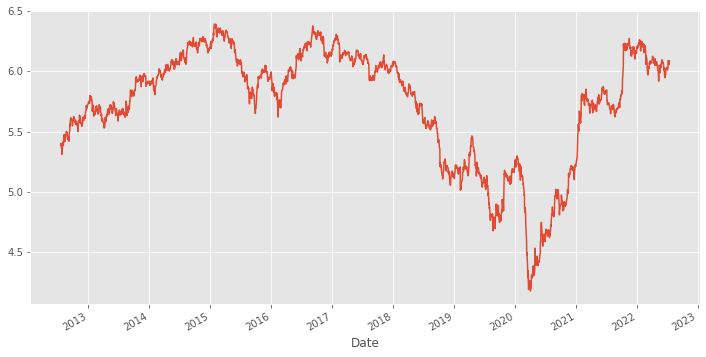

In [14]:
y = np.log(df["Close"])
y.plot()

In [15]:
y.index

DatetimeIndex(['2012-07-18', '2012-07-19', '2012-07-20', '2012-07-23',
               '2012-07-24', '2012-07-25', '2012-07-26', '2012-07-27',
               '2012-07-30', '2012-07-31',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Calculate rolling mean, exponentially weighted mean

In [16]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-11,6.080048,6.059562,6.055016
2022-07-12,6.065063,6.057987,6.055215
2022-07-13,6.057018,6.056442,6.055250
2022-07-14,6.059240,6.054889,6.055329
2022-07-15,6.087229,6.053753,6.055961


In [17]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18606566333622673
rmse over ewma:  0.1581524413253412


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

<AxesSubplot:xlabel='Date'>

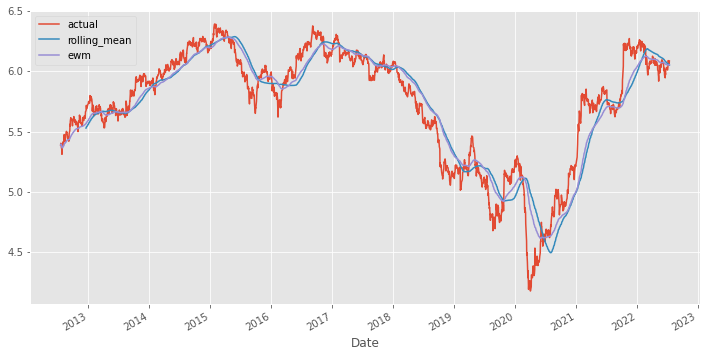

In [18]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [19]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.dropna())

ADF Statistic: -1.393212
p-value: 0.585526
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [20]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-07-18,5.390205,NaN,NaN
2012-07-19,5.404542,NaN,NaN
2012-07-20,5.398295,NaN,NaN
2012-07-23,5.364841,-0.025364,NaN
2012-07-24,5.363915,-0.040627,-0.015263
2012-07-25,5.350623,-0.047672,-0.007044
2012-07-26,5.312829,-0.052012,-0.004340
2012-07-27,5.349919,-0.013996,0.038016
2012-07-30,5.390656,0.040033,0.054029


In [21]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.diff(periods=1).dropna())

ADF Statistic: -48.545850
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


<AxesSubplot:xlabel='Date'>

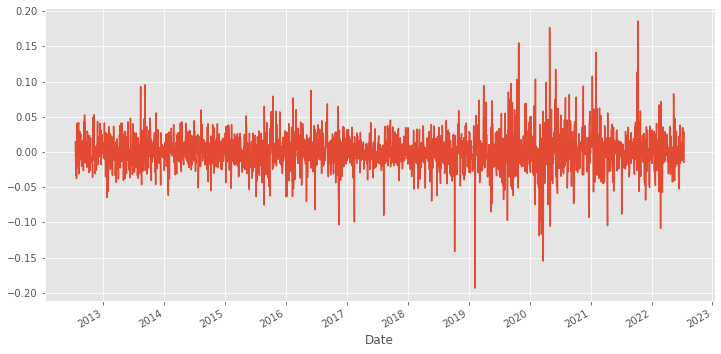

In [22]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

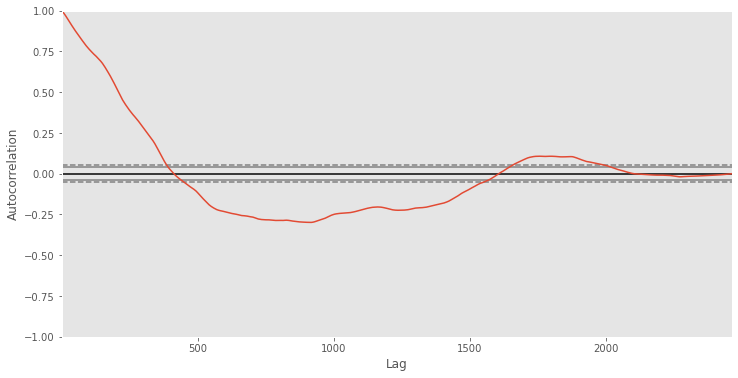

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [24]:
y = y.dropna()

In [25]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10817.813, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10816.907, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10816.890, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10819.540, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10815.118, Time=1.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.485 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5410.770
Date:                Thu, 28 Jul 2022   AIC                         -10819.540
Time:                        12:59:33   BIC                         -10813.731
Sample:                             0   HQIC                        -10817.429
                               - 2463                             

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been pr

                  0
count  2.462000e+03
mean   5.709058e-10
std    2.687647e-02
min   -1.936582e-01
25%   -1.361539e-02
50%   -2.831124e-04
75%    1.322949e-02
max    1.857541e-01


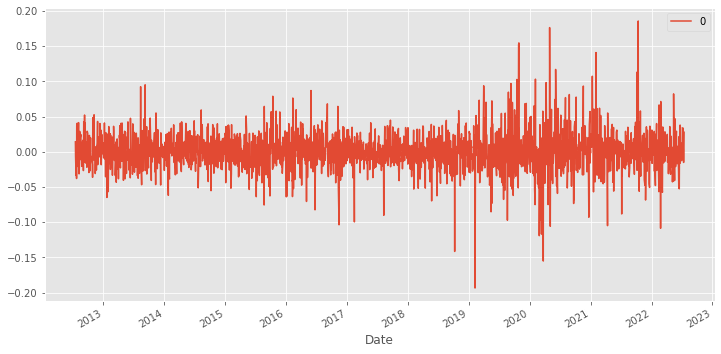

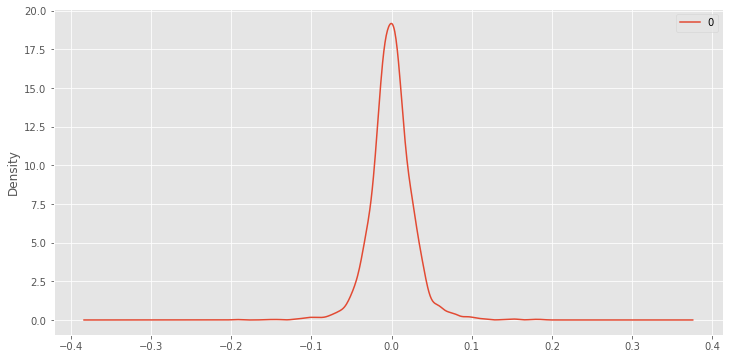

In [26]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=0

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [27]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2462
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5410.907
Method:                           css   S.D. of innovations              0.027
Date:                Thu, 28 Jul 2022   AIC                         -10817.813
Time:                        12:59:34   BIC                         -10806.196
Sample:                             1   HQIC                        -10813.592
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.523      0.601      -0.001       0.001
==============================================================================
"""

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


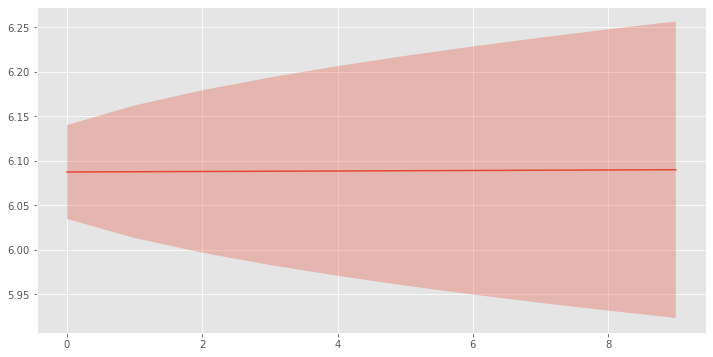

In [28]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(10)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [29]:
predictions[:10]

array([6.08751231, 6.08779542, 6.08807853, 6.08836165, 6.08864476,
       6.08892787, 6.08921098, 6.0894941 , 6.08977721, 6.09006032])

In [30]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=5.050940, actual=5.018934
predicted=5.018719, actual=4.971894
predicted=4.971652, actual=4.991452
predicted=4.991221, actual=4.923988
predicted=4.923718, actual=4.893727
predicted=4.893440, actual=4.909709
predicted=4.909432, actual=4.864067
predicted=4.863763, actual=4.872905
predicted=4.872606, actual=4.818263
predicted=4.817933, actual=4.808111
predicted=4.807775, actual=4.765587
predicted=4.765227, actual=4.820685
predicted=4.820356, actual=4.804431
predicted=4.804093, actual=4.803611
predicted=4.803273, actual=4.794964
predicted=4.794621, actual=4.798679
predicted=4.798339, actual=4.794136
predicted=4.793794, actual=4.819071
predicted=4.818743, actual=4.722064
predicted=4.721680, actual=4.679350
predicted=4.678942, actual=4.709981
predicted=4.709591, actual=4.705468
predicted=4.705076, actual=4.790404
predicted=4.790061, actual=4.756603
predicted=4.756240, actual=4.738827
predicted=4.738454, actual=4.759607
predicted=4.759246, actual=4.724286
predicted=4.723905, actual=4

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=4.802866, actual=4.900448
predicted=4.900169, actual=4.851640
predicted=4.851333, actual=4.864067
predicted=4.863767, actual=4.856707
predicted=4.856403, actual=4.804021
predicted=4.803688, actual=4.801970
predicted=4.801636, actual=4.821893
predicted=4.821570, actual=4.892227
predicted=4.891944, actual=4.851249
predicted=4.850943, actual=4.874434
predicted=4.874141, actual=4.812591
predicted=4.812264, actual=4.824306
predicted=4.823985, actual=4.786658
predicted=4.786317, actual=4.766013
predicted=4.765660, actual=4.747537
predicted=4.747174, actual=4.807294
predicted=4.806965, actual=4.784571
predicted=4.784229, actual=4.766438
predicted=4.766086, actual=4.794964
predicted=4.794628, actual=4.760463
predicted=4.760108, actual=4.798267
predicted=4.797933, actual=4.850858
predicted=4.850554, actual=4.843793
predicted=4.843486, actual=4.835091
predicted=4.834778, actual=4.938065
predicted=4.937810, actual=4.918885
predicted=4.918621, actual=4.880906
predicted=4.880620, actual=4

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5.098794, actual=5.110179
predicted=5.110028, actual=5.213576
predicted=5.213481, actual=5.186547
predicted=5.186438, actual=5.156754
predicted=5.156628, actual=5.129307
predicted=5.129166, actual=5.134327
predicted=5.134189, actual=5.141371
predicted=5.141237, actual=5.132853
predicted=5.132715, actual=5.130490
predicted=5.130351, actual=5.130490
predicted=5.130351, actual=5.085124
predicted=5.084961, actual=5.062911
predicted=5.062736, actual=5.065755
predicted=5.065581, actual=5.014959
predicted=5.014758, actual=5.009968
predicted=5.009765, actual=4.973625
predicted=4.973403, actual=4.978456
predicted=4.978236, actual=4.859425
predicted=4.859141, actual=4.831509
predicted=4.831210, actual=4.870223
predicted=4.869946, actual=4.837868
predicted=4.837573, actual=4.834296
predicted=4.833999, actual=4.737951
predicted=4.737604, actual=4.660605
predicted=4.660216, actual=4.594109
predicted=4.593685, actual=4.477337
predicted=4.476851, actual=4.497028
predicted=4.496553, actual=4

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=4.706922, actual=4.748838
predicted=4.748506, actual=4.713576
predicted=4.713227, actual=4.713127
predicted=4.712778, actual=4.664853
predicted=4.664479, actual=4.656813
predicted=4.656435, actual=4.610158
predicted=4.609756, actual=4.551242
predicted=4.550810, actual=4.558079
predicted=4.557650, actual=4.567987
predicted=4.567564, actual=4.629863
predicted=4.629472, actual=4.631325
predicted=4.630935, actual=4.648230
predicted=4.647848, actual=4.652054
predicted=4.651675, actual=4.642466
predicted=4.642082, actual=4.619073
predicted=4.618677, actual=4.599655
predicted=4.599250, actual=4.587515
predicted=4.587104, actual=4.612642
predicted=4.612244, actual=4.620551
predicted=4.620157, actual=4.639088
predicted=4.638704, actual=4.691348
predicted=4.690990, actual=4.691807
predicted=4.691449, actual=4.657288
predicted=4.656914, actual=4.672361
predicted=4.671995, actual=4.678421
predicted=4.678057, actual=4.682131
predicted=4.681770, actual=4.655388
predicted=4.655013, actual=4

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=4.869199, actual=4.894101
predicted=4.893857, actual=4.919981
predicted=4.919750, actual=4.895598
predicted=4.895355, actual=4.910078
predicted=4.909842, actual=4.903792
predicted=4.903553, actual=4.882044
predicted=4.881795, actual=4.887714
predicted=4.887467, actual=4.889221
predicted=4.888975, actual=4.898586
predicted=4.898345, actual=4.911919
predicted=4.911685, actual=4.924714
predicted=4.924486, actual=4.934474
predicted=4.934251, actual=4.948760
predicted=4.948544, actual=4.983607
predicted=4.983408, actual=5.016949
predicted=5.016766, actual=5.018603
predicted=5.018422, actual=4.986001
predicted=4.985804, actual=5.002939
predicted=5.002750, actual=5.062595
predicted=5.062435, actual=5.156178
predicted=5.156063, actual=5.123666
predicted=5.123536, actual=5.130490
predicted=5.130364, actual=5.139908
predicted=5.139786, actual=5.147785
predicted=5.147667, actual=5.144292
predicted=5.144172, actual=5.157617
predicted=5.157504, actual=5.194899
predicted=5.194805, actual=5

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5.105505, actual=5.131081
predicted=5.130957, actual=5.170200
predicted=5.170094, actual=5.227627
predicted=5.227548, actual=5.211942
predicted=5.211856, actual=5.215751
predicted=5.215667, actual=5.214120
predicted=5.214036, actual=5.228431
predicted=5.228353, actual=5.253843
predicted=5.253777, actual=5.263726
predicted=5.263665, actual=5.275049
predicted=5.274993, actual=5.281934
predicted=5.281882, actual=5.289024
predicted=5.288976, actual=5.396578
predicted=5.396581, actual=5.471430
predicted=5.471469, actual=5.491414
predicted=5.491462, actual=5.501666
predicted=5.501720, actual=5.561835
predicted=5.561917, actual=5.505128
predicted=5.505183, actual=5.555476
predicted=5.555555, actual=5.616407
predicted=5.616515, actual=5.671948
predicted=5.672082, actual=5.667637
predicted=5.667769, actual=5.631749
predicted=5.631864, actual=5.589120
predicted=5.589214, actual=5.586499
predicted=5.586593, actual=5.571013
predicted=5.571099, actual=5.633360
predicted=5.633476, actual=5

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=5.762536, actual=5.777652
predicted=5.777830, actual=5.785823
predicted=5.786004, actual=5.813981
predicted=5.814175, actual=5.844993
predicted=5.845201, actual=5.865760
predicted=5.865977, actual=5.838750
predicted=5.838955, actual=5.842820
predicted=5.843026, actual=5.860074
predicted=5.860288, actual=5.874790
predicted=5.875012, actual=5.865618
predicted=5.865835, actual=5.856074
predicted=5.856287, actual=5.845427
predicted=5.845634, actual=5.821269
predicted=5.821466, actual=5.812039
predicted=5.812231, actual=5.822750
predicted=5.822947, actual=5.814877
predicted=5.815070, actual=5.813085
predicted=5.813278, actual=5.827916
predicted=5.828115, actual=5.837147
predicted=5.837350, actual=5.833494
predicted=5.833695, actual=5.827768
predicted=5.827967, actual=5.841368
predicted=5.841573, actual=5.843255
predicted=5.843460, actual=5.846728
predicted=5.846935, actual=5.758586
predicted=5.758753, actual=5.759217
predicted=5.759384, actual=5.724728
predicted=5.724880, actual=5

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=6.198116, actual=6.198377
predicted=6.198726, actual=6.153158
predicted=6.153487, actual=6.102670
predicted=6.102978, actual=6.117216
predicted=6.117529, actual=6.153796
predicted=6.154125, actual=6.157720
predicted=6.158051, actual=6.147613
predicted=6.147939, actual=6.155177
predicted=6.155506, actual=6.174203
predicted=6.174540, actual=6.165418
predicted=6.165751, actual=6.153583
predicted=6.153911, actual=6.178774
predicted=6.179112, actual=6.209797
predicted=6.210148, actual=6.193589
predicted=6.193934, actual=6.193895
predicted=6.194240, actual=6.192056
predicted=6.192400, actual=6.195629
predicted=6.195974, actual=6.221981
predicted=6.222337, actual=6.217205
predicted=6.217559, actual=6.229004
predicted=6.229363, actual=6.238227
predicted=6.238590, actual=6.234215
predicted=6.234576, actual=6.263398
predicted=6.263772, actual=6.235978
predicted=6.236340, actual=6.255462
predicted=6.255832, actual=6.245525
predicted=6.245890, actual=6.218301
predicted=6.218655, actual=6

In [31]:
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 0.034


In [32]:
result = pd.DataFrame(np.exp(y))[train_size:]
result.columns = ["actual"]
result["prediction"] = np.exp(predictions)
result

,actual,prediction
Date,,
2019-07-24,151.250000,156.169261
2019-07-25,144.300003,151.217431
2019-07-26,147.149994,144.265015
2019-07-29,137.550003,147.116002
2019-07-30,133.449997,137.512875
...,...,...
2022-07-11,437.049988,441.675819
2022-07-12,430.549988,437.172664
2022-07-13,427.100006,430.668166


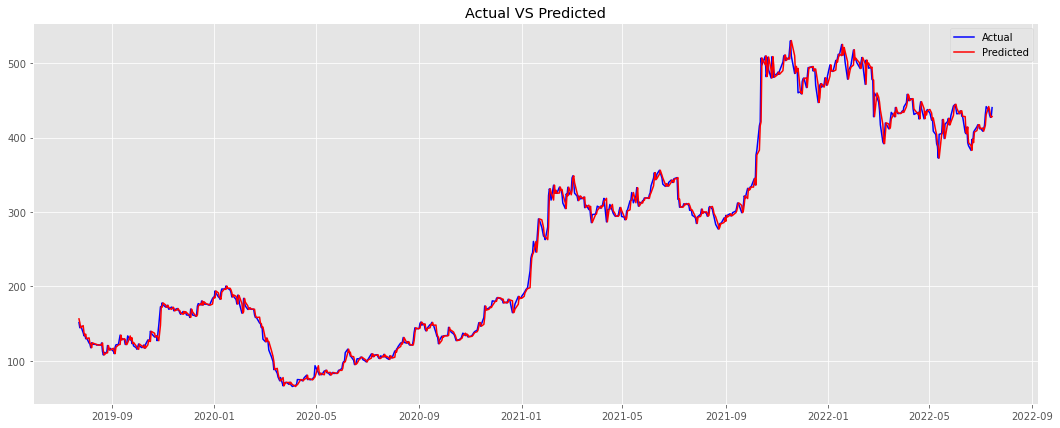

In [33]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(result["actual"],color='blue',label='Actual')
plt.plot(result["prediction"], color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [34]:
model = ARIMA(y, order=(0,1,0))
model_fit = model.fit()

C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\HP\anaconda3\shreyansh data  science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been pr

In [35]:
predictions=pd.Series(model_fit.fittedvalues, copy=True)
print(predictions.head())

Date
2012-07-19    0.000283
2012-07-20    0.000283
2012-07-23    0.000283
2012-07-24    0.000283
2012-07-25    0.000283
dtype: float64


In [36]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2012-07-19    0.000283
2012-07-20    0.000566
2012-07-23    0.000849
2012-07-24    0.001132
2012-07-25    0.001416
dtype: float64


In [37]:
predictions_log=pd.Series(y, index=y.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log

Date
2012-07-18    5.390205
2012-07-19    5.404825
2012-07-20    5.398861
2012-07-23    5.365690
2012-07-24    5.365047
                ...   
2022-07-11    6.775938
2022-07-12    6.761237
2022-07-13    6.753475
2022-07-14    6.755980
2022-07-15    6.784252
Length: 2463, dtype: float64

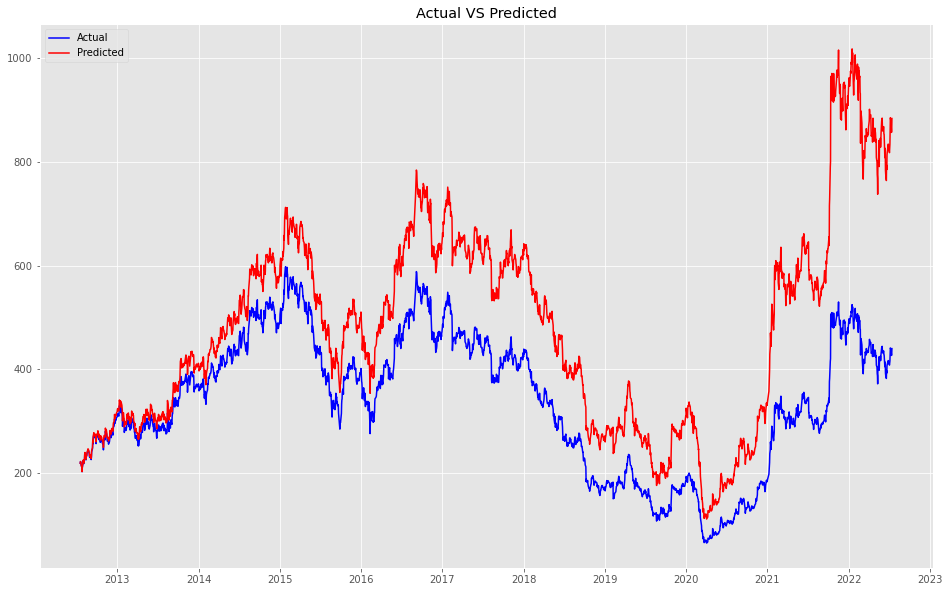

In [38]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(16,10))
plt.plot(df["Close"],color='blue',label='Actual')
plt.plot(predictions_ARIMA,color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [39]:
forecast=model_fit.forecast(steps=9)[0]
np.exp(forecast)

array([440.32465594, 440.44933496, 440.57404928, 440.69879892,
       440.82358388, 440.94840417, 441.07325981, 441.1981508 ,
       441.32307716])

In [40]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year,end.month,end.day-10)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [41]:
df['Close']

Date
2022-07-18    450.899994
2022-07-19    449.049988
2022-07-20    453.450012
2022-07-21    454.850006
2022-07-22    454.899994
2022-07-25    449.549988
2022-07-26    441.149994
2022-07-27    444.049988
2022-07-28    442.450012
Name: Close, dtype: float64

In [42]:
result = pd.DataFrame(df['Close'])
result.columns = ["actual"]
result["forecast"] = np.exp(forecast)
result

,actual,forecast
Date,,
2022-07-18,450.899994,440.324656
2022-07-19,449.049988,440.449335
2022-07-20,453.450012,440.574049
2022-07-21,454.850006,440.698799
2022-07-22,454.899994,440.823584
2022-07-25,449.549988,440.948404
2022-07-26,441.149994,441.073260
2022-07-27,444.049988,441.198151
2022-07-28,442.450012,441.323077


In [43]:
error = mean_squared_error(result["actual"] , result["forecast"] )
print('Forecast RMSE: %.3f' % np.sqrt(error))

Forecast RMSE: 9.623
